<a href="https://colab.research.google.com/github/Tasin5541/Face_Recognizer/blob/master/Face_Recognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Library

In [ ]:
import matplotlib as mpl
mpl.use("Agg")
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from imutils import paths
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image, ExifTags
import numpy as np
import pickle
import cv2
import os
import math

##Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"

Mounted at /content/gdrive


##Dataset

In [ ]:
dataset = root_dir + 'University/CSE 4.2/Soft Computing Lab/Project/Data'

In [ ]:
LABELS = set(['Tasin', 'Ifti', 'Deepak'])

imagePaths = list(paths.list_images(dataset))

In [ ]:
print(imagePaths)

['/content/gdrive/My Drive/University/CSE 4.2/Soft Computing Lab/Project/Data/Ifti/IMG_20200818_191059.jpg', '/content/gdrive/My Drive/University/CSE 4.2/Soft Computing Lab/Project/Data/Ifti/IMG_20200818_191107.jpg', '/content/gdrive/My Drive/University/CSE 4.2/Soft Computing Lab/Project/Data/Ifti/IMG_20200818_173148.jpg', '/content/gdrive/My Drive/University/CSE 4.2/Soft Computing Lab/Project/Data/Ifti/IMG_20200818_173141.jpg', '/content/gdrive/My Drive/University/CSE 4.2/Soft Computing Lab/Project/Data/Ifti/IMG_20200818_173138.jpg', '/content/gdrive/My Drive/University/CSE 4.2/Soft Computing Lab/Project/Data/Ifti/IMG_20200818_172530.jpg', '/content/gdrive/My Drive/University/CSE 4.2/Soft Computing Lab/Project/Data/Ifti/IMG_20200818_172350.jpg', '/content/gdrive/My Drive/University/CSE 4.2/Soft Computing Lab/Project/Data/Ifti/IMG_20200818_172343.jpg', '/content/gdrive/My Drive/University/CSE 4.2/Soft Computing Lab/Project/Data/Ifti/IMG_20200818_172336.jpg', '/content/gdrive/My Drive/U

###Load Image

In [ ]:
data = []
labels = []

print("[INFO] loading images...")

for imagePath in imagePaths:
	label = imagePath.split(os.path.sep)[-2]

	if label not in LABELS:
		continue

	image = cv2.imread(imagePath)
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	image = cv2.resize(image, (224, 224))

	data.append(image)
	labels.append(label)
 
print("[INFO] images loaded...")

[INFO] loading images...
[INFO] images loaded...


In [ ]:
print(labels)

['Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti', 'Ifti',

In [ ]:
# convert the data and labels to NumPy arrays
data = np.array(data)
labels = np.array(labels)
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=1 - train_ratio, stratify=labels, random_state=42)
(valX, testX, valY, testY) = train_test_split(testX, testY,
	test_size=test_ratio/(test_ratio + validation_ratio), stratify=testY, random_state=42)

###Augmentation

In [ ]:
# initialize the training data augmentation object
trainAug = ImageDataGenerator(
	rotation_range=0,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

valAug = ImageDataGenerator()

mean = np.array([123.68, 116.779, 103.939], dtype="float32")
trainAug.mean = mean
valAug.mean = mean

In [ ]:
epochs = 50
b_size = 32

##Model

####ResNet50

In [ ]:
baseModel = ResNet50(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(len(lb.classes_), activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
	layer.trainable = False

####ResNet152

In [ ]:
baseModel = ResNet152(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(len(lb.classes_), activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
	layer.trainable = False

234700800/234698864 [==============================] - 12s 0us/step


##LR Finder

In [ ]:
# compile our model (this needs to be done after our setting our
# layers to being non-trainable)
print("[INFO] compiling model...")
opt = SGD(lr=1e-4, momentum=0.9, decay=1e-4 / epochs)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...


In [ ]:
# import the necessary packages
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
import tempfile
class LearningRateFinder:
	def __init__(self, model, stopFactor=4, beta=0.98):
		# store the model, stop factor, and beta value (for computing
		# a smoothed, average loss)
		self.model = model
		self.stopFactor = stopFactor
		self.beta = beta
		# initialize our list of learning rates and losses,
		# respectively
		self.lrs = []
		self.losses = []
		# initialize our learning rate multiplier, average loss, best
		# loss found thus far, current batch number, and weights file
		self.lrMult = 1
		self.avgLoss = 0
		self.bestLoss = 1e9
		self.batchNum = 0
		self.weightsFile = None

	def reset(self):
		# re-initialize all variables from our constructor
		self.lrs = []
		self.losses = []
		self.lrMult = 1
		self.avgLoss = 0
		self.bestLoss = 1e9
		self.batchNum = 0
		self.weightsFile = None

	def is_data_iter(self, data):
		# define the set of class types we will check for
		iterClasses = ["NumpyArrayIterator", "DirectoryIterator",
			 "DataFrameIterator", "Iterator", "Sequence"]
		# return whether our data is an iterator
		return data.__class__.__name__ in iterClasses

	def on_batch_end(self, batch, logs):
		# grab the current learning rate and add log it to the list of
		# learning rates that we've tried
		lr = K.get_value(self.model.optimizer.lr)
		self.lrs.append(lr)
		# grab the loss at the end of this batch, increment the total
		# number of batches processed, compute the average average
		# loss, smooth it, and update the losses list with the
		# smoothed value
		l = logs["loss"]
		self.batchNum += 1
		self.avgLoss = (self.beta * self.avgLoss) + ((1 - self.beta) * l)
		smooth = self.avgLoss / (1 - (self.beta ** self.batchNum))
		self.losses.append(smooth)
		# compute the maximum loss stopping factor value
		stopLoss = self.stopFactor * self.bestLoss
		# check to see whether the loss has grown too large
		if self.batchNum > 1 and smooth > stopLoss:
			# stop returning and return from the method
			self.model.stop_training = True
			return
		# check to see if the best loss should be updated
		if self.batchNum == 1 or smooth < self.bestLoss:
			self.bestLoss = smooth
		# increase the learning rate
		lr *= self.lrMult
		K.set_value(self.model.optimizer.lr, lr)
  
	def find(self, trainData, startLR, endLR, epochs=None,
		stepsPerEpoch=None, batchSize=32, sampleSize=2048,
		verbose=1):
		# reset our class-specific variables
		self.reset()
		# determine if we are using a data generator or not
		useGen = self.is_data_iter(trainData)
		# if we're using a generator and the steps per epoch is not
		# supplied, raise an error
		if useGen and stepsPerEpoch is None:
			msg = "Using generator without supplying stepsPerEpoch"
			raise Exception(msg)
		# if we're not using a generator then our entire dataset must
		# already be in memory
		elif not useGen:
			# grab the number of samples in the training data and
			# then derive the number of steps per epoch
			numSamples = len(trainData[0])
			stepsPerEpoch = np.ceil(numSamples / float(batchSize))
		# if no number of training epochs are supplied, compute the
		# training epochs based on a default sample size
		if epochs is None:
			epochs = int(np.ceil(sampleSize / float(stepsPerEpoch)))
   		# compute the total number of batch updates that will take
		# place while we are attempting to find a good starting
		# learning rate
		numBatchUpdates = epochs * stepsPerEpoch
		# derive the learning rate multiplier based on the ending
		# learning rate, starting learning rate, and total number of
		# batch updates
		self.lrMult = (endLR / startLR) ** (1.0 / numBatchUpdates)
		# create a temporary file path for the model weights and
		# then save the weights (so we can reset the weights when we
		# are done)
		self.weightsFile = tempfile.mkstemp()[1]
		self.model.save_weights(self.weightsFile)
		# grab the *original* learning rate (so we can reset it
		# later), and then set the *starting* learning rate
		origLR = K.get_value(self.model.optimizer.lr)
		K.set_value(self.model.optimizer.lr, startLR)
		# construct a callback that will be called at the end of each
		# batch, enabling us to increase our learning rate as training
		# progresses
		callback = LambdaCallback(on_batch_end=lambda batch, logs:
			self.on_batch_end(batch, logs))
		# check to see if we are using a data iterator
		if useGen:
			self.model.fit(
				x=trainData,
				steps_per_epoch=stepsPerEpoch,
				epochs=epochs,
				verbose=verbose,
				callbacks=[callback])
		# otherwise, our entire training data is already in memory
		else:
			# train our model using Keras' fit method
			self.model.fit(
				x=trainData[0], y=trainData[1],
				batch_size=batchSize,
				epochs=epochs,
				callbacks=[callback],
				verbose=verbose)
		# restore the original model weights and learning rate
		self.model.load_weights(self.weightsFile)
		K.set_value(self.model.optimizer.lr, origLR)
  
	def plot_loss(self, skipBegin=10, skipEnd=1, title=""):
		# grab the learning rate and losses values to plot
		lrs = self.lrs[skipBegin:-skipEnd]
		losses = self.losses[skipBegin:-skipEnd]
		# plot the learning rate vs. loss
		plt.plot(lrs, losses)
		plt.xscale("log")
		plt.xlabel("Learning Rate (Log Scale)")
		plt.ylabel("Loss")
		# if the title is not empty, add it to the plot
		if title != "":
			plt.title(title)

[INFO] finding learning rate...
Epoch 1/63
33/33 [==============================] - 10s 310ms/step - loss: 1.9886 - accuracy: 0.2922
Epoch 2/63
33/33 [==============================] - 10s 312ms/step - loss: 1.9594 - accuracy: 0.2748
Epoch 3/63
33/33 [==============================] - 10s 314ms/step - loss: 1.9961 - accuracy: 0.2961
Epoch 4/63
33/33 [==============================] - 11s 319ms/step - loss: 2.0226 - accuracy: 0.2699
Epoch 5/63
33/33 [==============================] - 10s 318ms/step - loss: 2.0145 - accuracy: 0.2961
Epoch 6/63
33/33 [==============================] - 10s 313ms/step - loss: 2.0197 - accuracy: 0.2777
Epoch 7/63
33/33 [==============================] - 10s 314ms/step - loss: 1.9606 - accuracy: 0.2728
Epoch 8/63
33/33 [==============================] - 10s 314ms/step - loss: 2.0088 - accuracy: 0.2903
Epoch 9/63
33/33 [==============================] - 10s 313ms/step - loss: 1.9489 - accuracy: 0.2913
Epoch 10/63
33/33 [==============================] - 10s 31

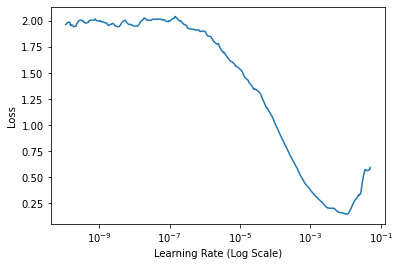

In [ ]:
print("[INFO] finding learning rate...")
lrf = LearningRateFinder(model)
lrf.find(
  trainAug.flow(trainX, trainY, batch_size=b_size),
  1e-10, 1e+1,
  stepsPerEpoch=np.ceil((len(trainX) / float(b_size))),
  batchSize=b_size)

lrf.plot_loss()

print("[INFO] learning rate finder complete")
print("[INFO] examine plot and adjust learning rates before training")

##LR Range

In [ ]:
min_lr = 1e-5
max_lr = 1e-3
STEP_SIZE = 8

##Training ResNet50

In [ ]:
checkpoint_filepath = root_dir+"University/CSE 4.2/Soft Computing Lab/Project/Tensorflow/model/tmp/checkpoint.hdf5"

model_checkpoint_callback = tensorflow.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
print("[INFO] compiling model...")
opt = SGD(lr=max_lr, momentum=0.9, decay=max_lr / epochs)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

print("[INFO] training head...")
H = model.fit(
	x=trainAug.flow(trainX, trainY, batch_size=b_size),
	steps_per_epoch=len(trainX) // b_size,
	validation_data=valAug.flow(valX, valY),
	validation_steps=len(testX) // b_size,
	epochs=epochs,
	callbacks=[model_checkpoint_callback])

[INFO] compiling model...
[INFO] training head...
Epoch 1/50
66/66 [==============================] - 29s 439ms/step - loss: 0.6194 - accuracy: 0.7488 - val_loss: 0.2355 - val_accuracy: 0.9180
Epoch 2/50
66/66 [==============================] - 26s 397ms/step - loss: 0.2460 - accuracy: 0.9088 - val_loss: 0.1344 - val_accuracy: 0.9727
Epoch 3/50
66/66 [==============================] - 26s 395ms/step - loss: 0.1897 - accuracy: 0.9340 - val_loss: 0.0932 - val_accuracy: 0.9922
Epoch 4/50
66/66 [==============================] - 26s 393ms/step - loss: 0.1390 - accuracy: 0.9549 - val_loss: 0.0768 - val_accuracy: 0.9883
Epoch 5/50
66/66 [==============================] - 26s 399ms/step - loss: 0.1065 - accuracy: 0.9706 - val_loss: 0.0651 - val_accuracy: 0.9922
Epoch 6/50
66/66 [==============================] - 26s 393ms/step - loss: 0.0977 - accuracy: 0.9720 - val_loss: 0.0606 - val_accuracy: 0.9883
Epoch 7/50
66/66 [==============================] - 26s 395ms/step - loss: 0.0905 - accuracy

In [ ]:
model.load_weights(checkpoint_filepath)

##Training ResNet152

In [ ]:
checkpoint_filepath = root_dir+"University/CSE 4.2/Soft Computing Lab/Project/Tensorflow/model/tmp/res152.hdf5"

model_checkpoint_callback = tensorflow.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
print("[INFO] compiling model...")
opt = SGD(lr=max_lr, momentum=0.9, decay=max_lr / epochs)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

print("[INFO] training head...")
H = model.fit(
	x=trainAug.flow(trainX, trainY, batch_size=b_size),
	steps_per_epoch=len(trainX) // b_size,
	validation_data=valAug.flow(valX, valY),
	validation_steps=len(testX) // b_size,
	epochs=epochs,
	callbacks=[model_checkpoint_callback])

[INFO] compiling model...
[INFO] training head...
Epoch 1/20
66/66 [==============================] - 32s 485ms/step - loss: 0.5511 - accuracy: 0.7654 - val_loss: 0.2107 - val_accuracy: 0.9375
Epoch 2/20
66/66 [==============================] - 31s 467ms/step - loss: 0.2641 - accuracy: 0.9022 - val_loss: 0.1315 - val_accuracy: 0.9727
Epoch 3/20
66/66 [==============================] - 31s 476ms/step - loss: 0.1820 - accuracy: 0.9359 - val_loss: 0.1134 - val_accuracy: 0.9727
Epoch 4/20
66/66 [==============================] - 31s 465ms/step - loss: 0.1561 - accuracy: 0.9482 - val_loss: 0.0695 - val_accuracy: 0.9961
Epoch 5/20
66/66 [==============================] - 30s 462ms/step - loss: 0.1286 - accuracy: 0.9587 - val_loss: 0.0626 - val_accuracy: 0.9922
Epoch 6/20
66/66 [==============================] - 31s 465ms/step - loss: 0.1154 - accuracy: 0.9634 - val_loss: 0.0459 - val_accuracy: 0.9961
Epoch 7/20
66/66 [==============================] - 31s 464ms/step - loss: 0.1058 - accuracy

In [ ]:
model.load_weights(checkpoint_filepath)

#Evaluation

###Validation Set ResNet50

[INFO] evaluating Validation Set...

              precision    recall  f1-score   support

      Deepak       1.00      1.00      1.00       136
        Ifti       1.00      1.00      1.00       150
       Tasin       1.00      1.00      1.00       141

    accuracy                           1.00       427
   macro avg       1.00      1.00      1.00       427
weighted avg       1.00      1.00      1.00       427

Confusion Matrix


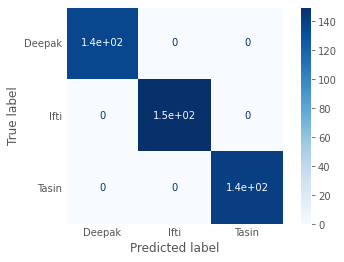

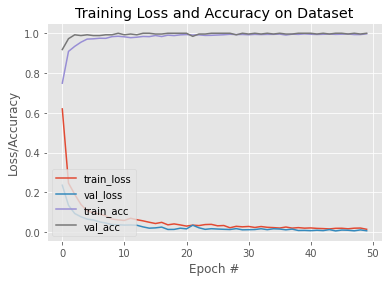

In [ ]:
print("[INFO] evaluating Validation Set...\n")
predictions = model.predict(x=valX.astype("float32"), batch_size=32)

print(classification_report(valY.argmax(axis=1), predictions.argmax(axis=1), target_names=lb.classes_))

print('Confusion Matrix')
cm = confusion_matrix(valY.argmax(axis=1), predictions.argmax(axis=1))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lb.classes_)
disp = disp.plot(include_values=True, cmap=plt.cm.Blues, ax=None, xticks_rotation='horizontal')

plt.tick_params(axis=u'both', which=u'both',length=0)
plt.grid(b=None)

# plot training loss and accuracy
N = epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

###Validation Set ResNet152

[INFO] evaluating Validation Set...

              precision    recall  f1-score   support

      Deepak       1.00      1.00      1.00       136
        Ifti       0.99      1.00      0.99       150
       Tasin       1.00      0.99      0.99       141

    accuracy                           1.00       427
   macro avg       1.00      1.00      1.00       427
weighted avg       1.00      1.00      1.00       427

Confusion Matrix


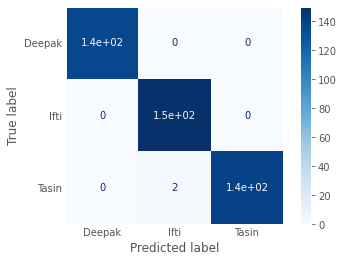

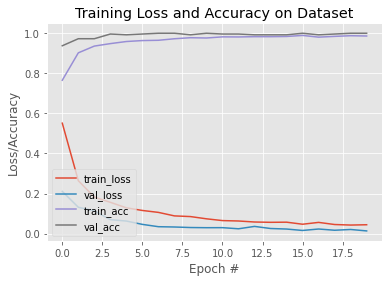

In [ ]:
print("[INFO] evaluating Validation Set...\n")
predictions = model.predict(x=valX.astype("float32"), batch_size=32)

print(classification_report(valY.argmax(axis=1), predictions.argmax(axis=1), target_names=lb.classes_))

print('Confusion Matrix')
cm = confusion_matrix(valY.argmax(axis=1), predictions.argmax(axis=1))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lb.classes_)
disp = disp.plot(include_values=True, cmap=plt.cm.Blues, ax=None, xticks_rotation='horizontal')

plt.tick_params(axis=u'both', which=u'both',length=0)
plt.grid(b=None)

# plot training loss and accuracy
N = epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

###Test Set

[INFO] evaluating Test Set...

              precision    recall  f1-score   support

      Deepak       1.00      0.99      0.99        92
        Ifti       0.99      1.00      1.00       100
       Tasin       1.00      1.00      1.00        94

    accuracy                           1.00       286
   macro avg       1.00      1.00      1.00       286
weighted avg       1.00      1.00      1.00       286

Confusion Matrix


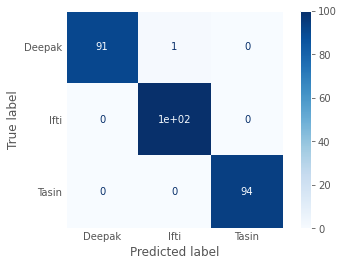

In [ ]:
print("[INFO] evaluating Test Set...\n")
predictions = model.predict(x=testX.astype("float32"), batch_size=32)

print(classification_report(testY.argmax(axis=1), predictions.argmax(axis=1), target_names=lb.classes_))

print('Confusion Matrix')
cm  = confusion_matrix(testY.argmax(axis=1), predictions.argmax(axis=1))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lb.classes_)
disp = disp.plot(include_values=True, cmap=plt.cm.Blues, ax=None, xticks_rotation='horizontal')

plt.tick_params(axis=u'both', which=u'both',length=0)
plt.grid(b=None)
plt.show()


##First 5 Predictions

In [ ]:
predictions = model.predict(x=testX.astype("float32"), batch_size=32)

for i, image in enumerate(testX):
  if i==5:
    break
  j = np.argmax(predictions[i])
  label = lb.classes_[j]
  plt.title(label)
  plt.imshow(image)
  plt.show()

##Wrong Predictions

In [ ]:
predictions = model.predict(x=testX.astype("float32"), batch_size=32)

In [ ]:
indices = []
for i in range(predictions.argmax(axis=1).shape[0]):
  if predictions.argmax(axis=1)[i] != testY.argmax(axis=1)[i]:
    indices.append(i)

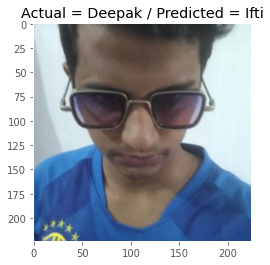

In [ ]:
for i in indices:
  j = np.argmax(predictions[i])
  k = np.argmax(testY[i])
  pred = lb.classes_[j]
  act = lb.classes_[k]
  plt.figure()
  plt.title("Actual = "+ act +" / Predicted = "+pred)
  plt.imshow(testX[i])
  plt.grid(b=None)
  plt.show()

#Save Model & Label

In [ ]:
print("[INFO] saving model...")
model.save(root_dir+"University/CSE 4.2/Soft Computing Lab/Project/Tensorflow/model/ResNet50_2.model", save_format="h5")

print("[INFO] saving label...")
f = open(root_dir+"University/CSE 4.2/Soft Computing Lab/Project/Tensorflow/output/lb.pickle", "wb")
f.write(pickle.dumps(lb))
f.close()

print("[INFO] ...DONE")

[INFO] saving model...
[INFO] saving label...
[INFO] ...DONE


##Load Model

In [ ]:
model = load_model(root_dir+"University/CSE 4.2/Soft Computing Lab/Project/Tensorflow/model/ResNet50_2.model")
lb = pickle.loads(open(root_dir+"University/CSE 4.2/Soft Computing Lab/Project/Tensorflow/output/lb.pickle", "rb").read())

In [ ]:
imagePaths = list(paths.list_images(root_dir + 'University/CSE 4.2/Soft Computing Lab/Project/Test'))

In [ ]:
test = []

print("[INFO] loading images...")

# loop over the image paths
for imagePath in imagePaths:
	image = cv2.imread(imagePath)
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	image = cv2.resize(image, (224, 224))
	
	test.append(image)

test = np.array(test) 
print("[INFO] images loaded...")

[INFO] loading images...
[INFO] images loaded...


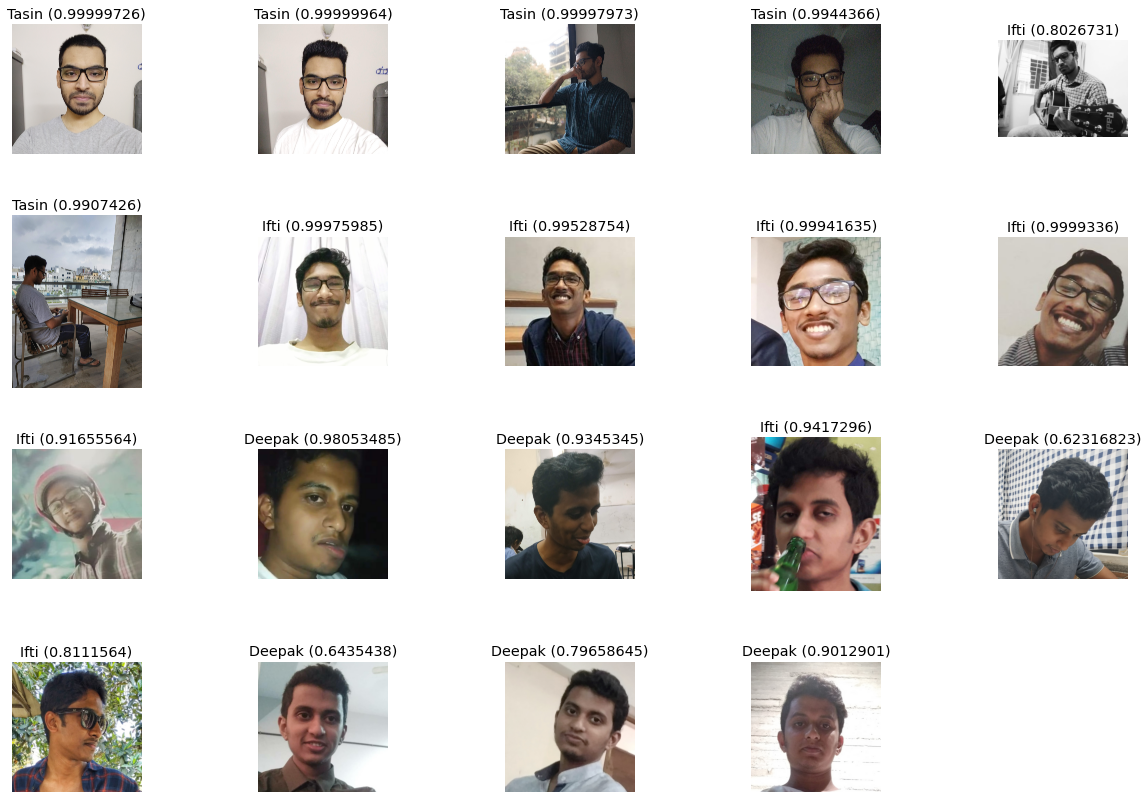

In [ ]:
predictions = model.predict(x=test.astype("float32"), batch_size=32)

plt.figure(figsize=[20,15])
plt.subplots_adjust(wspace = 0.9)
for i, image in enumerate(test):
  j = np.argmax(predictions[i])
  label = lb.classes_[j]

  dpi = mpl.rcParams['figure.dpi']
  im_data = plt.imread(imagePaths[i])
  height, width, depth = im_data.shape
  figsize = width / float(dpi), height / float(dpi)
  
  axarr = plt.subplot(math.ceil(len(predictions)/5),5,i+1)
  axarr.axis('off')
  plt.title(label + " " + "(" + str(predictions[i][j]) + ")")   
  img = Image.open(imagePaths[i])
  imgplot = plt.imshow(img)
plt.show()

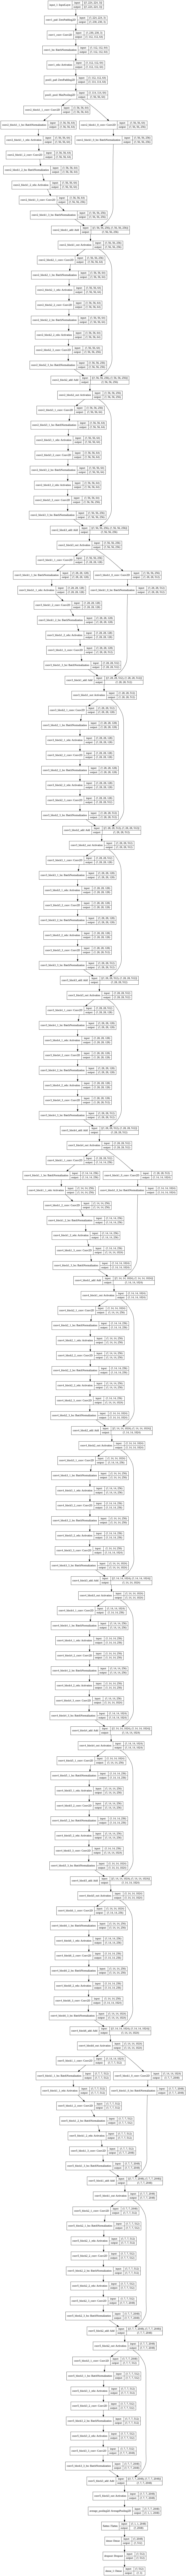

In [ ]:
tensorflow.keras.utils.plot_model(model, 'my_first_model.png', show_shapes=True)